<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning is about getting the parameters of what one model has learned on a dataset and applying them to another problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__)  # want 1.12+
print(torchvision.__version__)  # want 0.13+

2.0.1+cu118
0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3830, done.
remote: Counting objects: 100% (473/473), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 3830 (delta 248), reused 402 (delta 205), pack-reused 3357
Receiving objects: 100% (3830/3830), 649.88 MiB | 31.83 MiB/s, done.
Resolving deltas: 100% (2204/2204), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## 1. Get data

Get the pizza, steak, sushi data to build a transfer learning model on.

In [5]:
import os
import zipfile
from pathlib import Path
import requests

# Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# Download and prepare data if not exist
if image_path.is_dir():
  print(f'{image_path} directory exists, skipping download')
else:
  print(f'{image_path} not found, downloading')
  image_path.mkdir(parents=True, exist_ok=True)

  # download data
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print(f'Downloading data...')
    f.write(request.content)

  # unzip data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print(f'Unzipping data...')
    zip_ref.extractall(image_path)

  # remove zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')

data/pizza_steak_sushi not found, downloading
Unzipping data...


In [6]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Use `data_setup.py` and the `create_dataloaders()` function from `05. PyTorch Going Modular`.

The main question is: `how to transform it?`

In torchvision 0.13+ there are two ways:
1. Manually created transforms - define the transforms which the data will go through
2. Automatically created transforms - the transforms are defined by the model that will be used

**Important point**: when using a pretrained model, it is important that the data (including the custom data) that are passed through are **transformed** in the same way as the data the model trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning)

In [7]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [8]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd9538a6c80>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` +.13+ there is support for automatic data transform creation, based on the pretrained model weights used.

In [9]:
import torchvision

torchvision.__version__

'0.15.2+cu118'

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT    # DEFAULT = best available weights

weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create the pretrained weights
auto_transforms = weights.transforms()

auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd9538a6c50>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (different models)
4. Paperswithcode (models across different problem domains)

### 3.1 Which pretrained model to choose

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a space similar to the target one and customize it according to the problem at hand.

Three things to take under consideration:
1. Speed - how fast does it run
2. Size - how big is the model
3. Performance - how well does it work on the chosen problem

Where dows the model live?

Is it on a device?

Or on a server?

Looking at:
https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model to choose?

In this case study, the EffNetB0 looks like a good option in terms of performance vs size.

Provided that the resources were greater, picking a bigger model + more parameters + more general spectrum would be the best option.

### 3.2 Setting up a pretrained model

In [13]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 76.0MB/s]


In [14]:
# New method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of the model with `torchinfo.summary()`

In [18]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),  # [batch_size, color, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer

With a feature extraction model, typically the base layers of a pretrained/foundation model are "frozen" and the output layer is updated to suit a target problem.

In [19]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [20]:
summary(model=model,
        input_size=(1, 3, 224, 224),  # [batch_size, color, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [21]:
# Update the classifier head to suit the problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,
               inplace=True),
    nn.Linear(in_features=1280,   # feature vector coming in
              out_features=len(class_names))    # the number of classes
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [22]:
summary(model=model,
        input_size=(1, 3, 224, 224),  # [batch_size, color, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [24]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
# End the timer
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8856 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9211 | train_acc: 0.6562 | test_loss: 0.7920 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7553 | train_acc: 0.8672 | test_loss: 0.6486 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7376 | train_acc: 0.7070 | test_loss: 0.5954 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6272 | train_acc: 0.7656 | test_loss: 0.6106 | test_acc: 0.8968
[INFO] Total training time: 180.17088263000005 seconds


### 5. Evaluate model by plotting loss curves

[INFO] helper_functions.py not found, downloading...


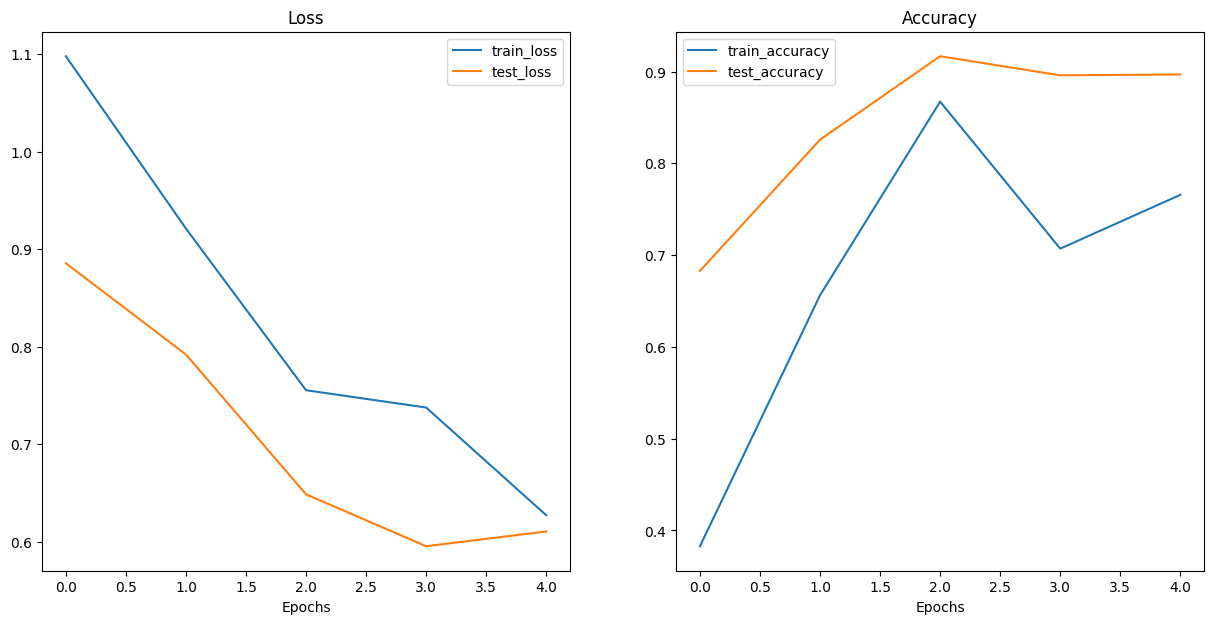

In [25]:
try:
  from helper_functions import plot_loss_curves
  print(f'[INFO] helper_functions.py imported successfully')
except:
  print(f'[INFO] helper_functions.py not found, downloading...')

  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py')
    f.write(request.content)

  from helper_functions import plot_loss_curves

# Plot the loss curves of the model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Things to keep in mind when making predictions/inference on test/custom data:

* Same shape - images need to be same shape as the ones the model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data should be on the same device as the model
* Same transform - if the custom data was transformed, the test and custom data will be transformed in the same way

To do all these thing automatically, a function `pred_and_plot_image()` should be implemented, which will:

1. Take in a trained model, a list of class names, a filepath of the target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if none exists
4. Ensure that the model is on the target device
5. Turn the model to evaluation mode to make sure it is ready for inference
6. Transform the target image and make sure the dimensions is suited for the model (relates to the batch size)
7. Make a prediction on the image by passing the model
8. Convert the model's output logits to prediction probabilities
9. Convert the model's prediction probabilities to prediction labels
10. Plot the image and set the title to the prediction label and the prediction probability

In [36]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)
  # 3. Create a transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)
  # 5. Turn on inferenc mode and eval mode
  model.eval()

  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)
    # 7. Make a prediction on the transformed image by passing it to the model
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  # 10. Plot the image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
  plt.axis(False);

In [37]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

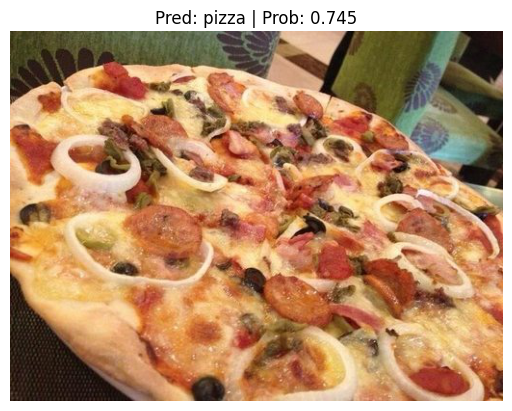

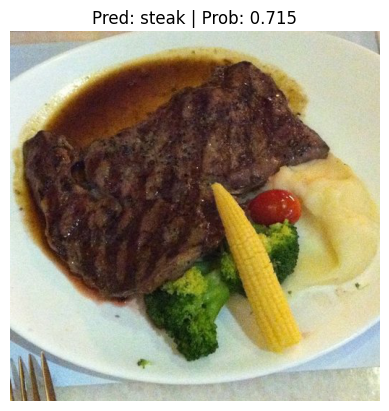

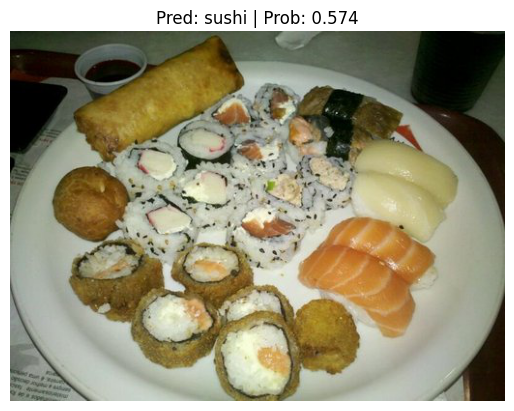

In [41]:
# Get a random list of image paths from the test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
# Make predictions on and plot images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 6.1 Making predictions on a custom image

In [42]:
# Download a custom image
import requests

custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download image if not exists
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists. Skipping download.')

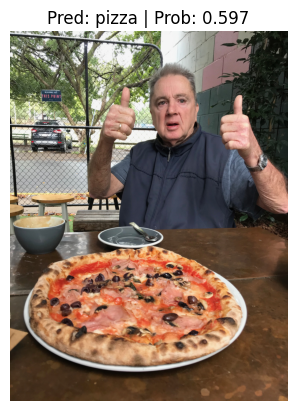

In [43]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)